<a href="https://colab.research.google.com/github/JuanDaGue/Seminario/blob/main/3_modelos_(Bs)_(Emcee).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emcee
!pip install corner

     |████████████████████████████████| 45 kB 2.2 MB/s 


In [2]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import seaborn as sns
import corner
import pymc3 as pm
import arviz as az

In [3]:
from google.colab import files
uploaded=files.upload()

Saving figure1_plotdata.csv to figure1_plotdata.csv


En los modelos vistos anteriormente, pese a conseguir que las constantes de la senal de 21 cm estuvienran dentro del rango de valores obtenidos por Edges, era evidente que hay parametros que no estan bien acotados, ya que en el grafico de esquina se puede observar como estos valores tratan de salirde los rangos en los que ajustamos los priors. En estos modelos vamos a ampliar los rangos de la fucnion prior tanto para el modelo con sigma fijo, como par el de sigma variable. 


### Carga de datos

In [4]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

In [5]:
Col=['b','r','darkorange','darkmagenta','gold','g','khaki','r','indigo','teal']
Cons_names=np.array(['Bow','Pyemcee','Pyemcee2','Natu_result','Intento','Natu'])

In [6]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables

x_C,y_C=Dat[:,0][Dat[:,0]>60.0] ,Dat[:,2][Dat[:,0]>60.0] # Variables
x_C,y_C=x_C[x_C<94.0],y_C[x_C<94.0]

Constante=np.zeros((6,9))
yerr=0.8


###funciones

In [7]:
"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf

In [8]:
def T_f(v,b0,b1,b2,b3,Te):
  vc=75.0 # frecuancia central (rean) 
  return (b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0)+Te*(1-np.exp(-b3*(v/vc)**-2.0))

def log_like(theta,x,y,sigma):
  v=x
  b0,b1,b2,b3,Te,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,b0,b1,b2,b3,Te,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
def log_prob(theta, x, y):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x, y,0.24)
def log_p(theta):
  b0,b1,b2,b3,Te,A,v0,w,tau = theta
  if 1700 < b0 < 1800.0 and -0.070 < b1 < -0.007 and  -2.1< b2 < -0.00011 and 0.0000 <b3 < 0.2 and 200 < Te < 2000 and 0.170 < A <9.0 and  77.3< v0 <108.5 and 8 <w < 64.0 and 1.0 <tau< 10.0:
    return 0.0
  return -np.inf

In [9]:

def nwalk_b(x,y,Sol,walkers,steps):
  N=len(Sol)  
  pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-4*(np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  pos=pos.T 
  #pos= Sol+ 10e-4* np.random.randn(walkers, N)
  nwalkers, ndim = pos.shape  

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler#discard=N, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [10]:
"""Función de Discrepancias
"""

def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//10 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=0.02
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      plt.xlabel("Observed Discrepancies")
      plt.xlabel("Simulated Discrepancies")

      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

# Modelo $b_n$ con sigma fijo

In [11]:
Sol=Sol_forz=np.array([1750.88, -0.060 ,-0.045,0.0006,980,6.4,97.3,40.6,4.5])
#Sol=Sol_forz=np.array([1750.88, -0.0675 ,-0.078,0.0000006,1100,0.5,78.3,20.6,4.5])
yerr=0.15
steps=8000 #pasos
walkers=500
samples=nwalk_b(x,y,Sol,walkers,steps)

100%|██████████| 8000/8000 [06:59<00:00, 19.08it/s]


In [12]:
params=samples.get_chain(discard=500, thin=500, flat=True)#parametros

popt=np.array(params.mean(axis=0))

In [13]:
params.shape

(7500, 9)

<Figure size 432x288 with 0 Axes>

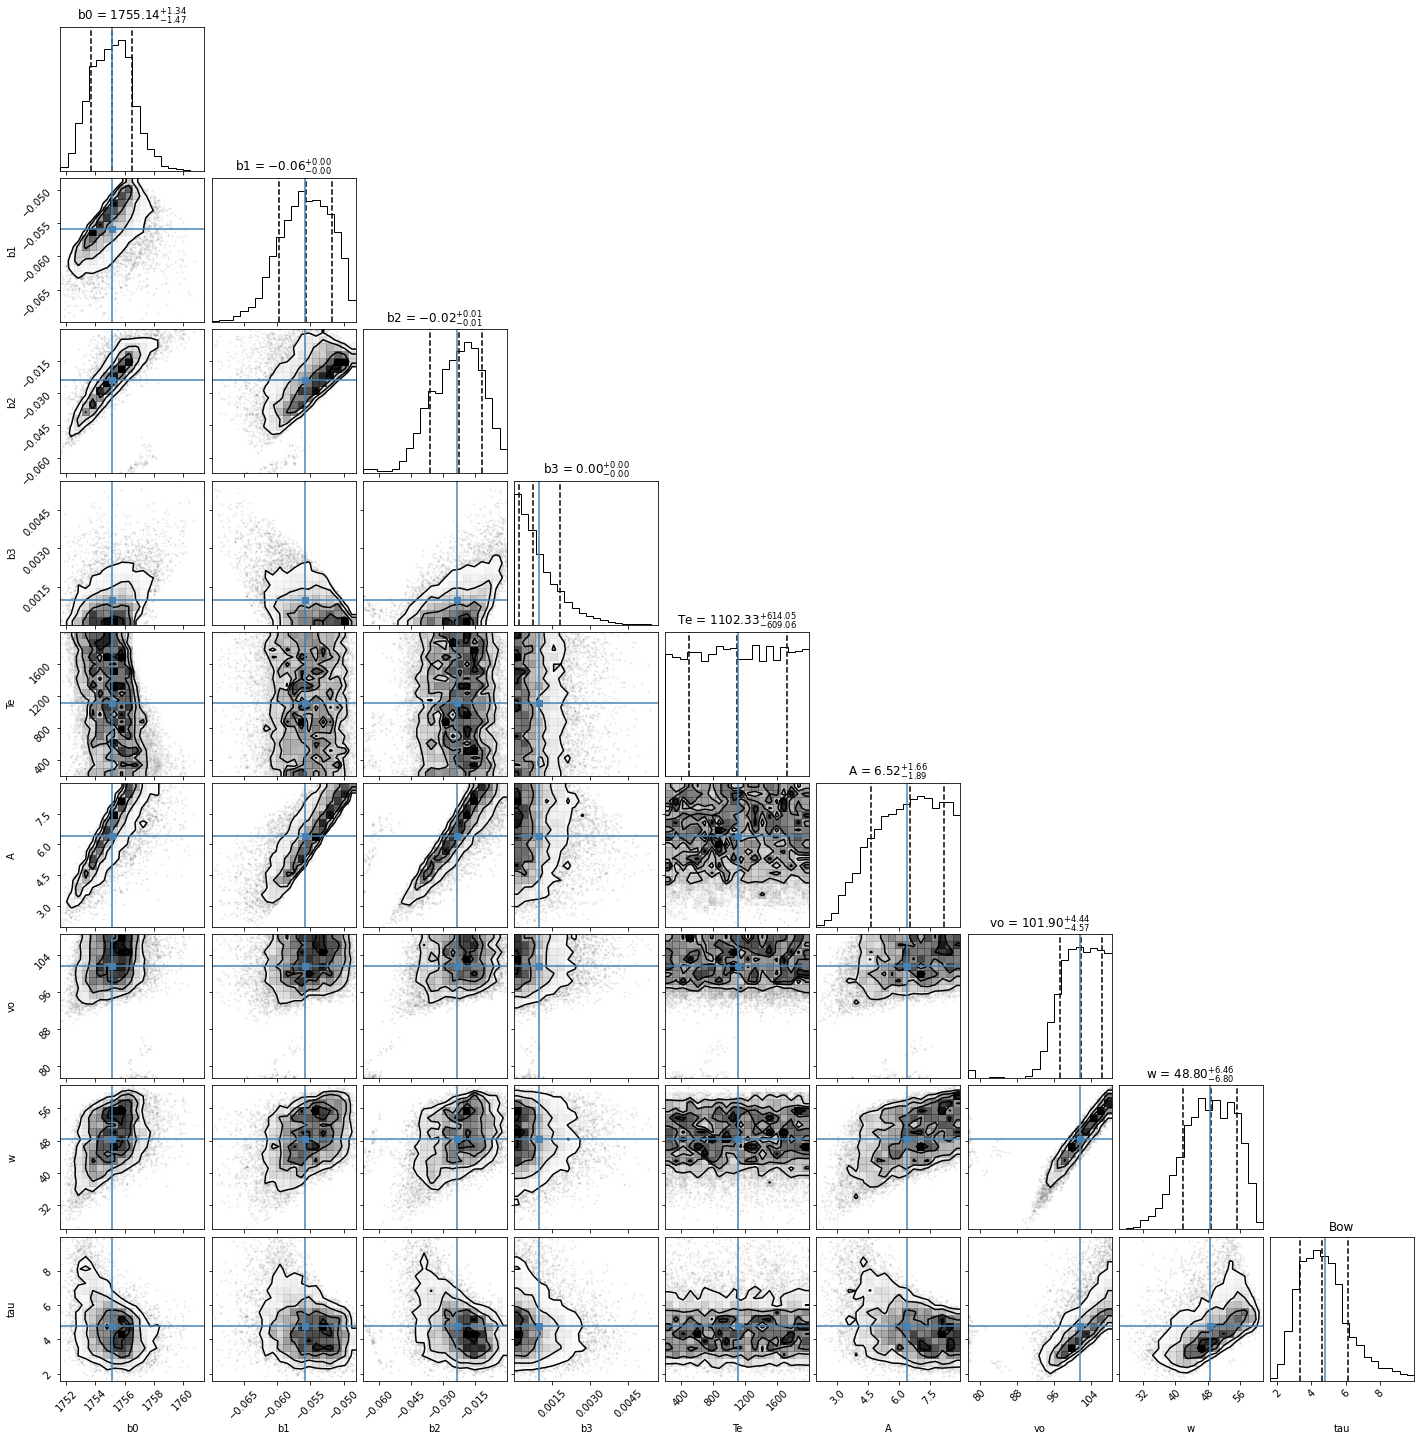

In [14]:
Nlen=1
names=np.array(['b0','b1','b2','b3','Te','A','vo','w','tau'])
plt.figure()

corner.corner(params,labels=names,quantiles=[0.16, 0.5, 0.84],truths=popt,show_titles=True)
plt.title('Bow') 
plt.show()

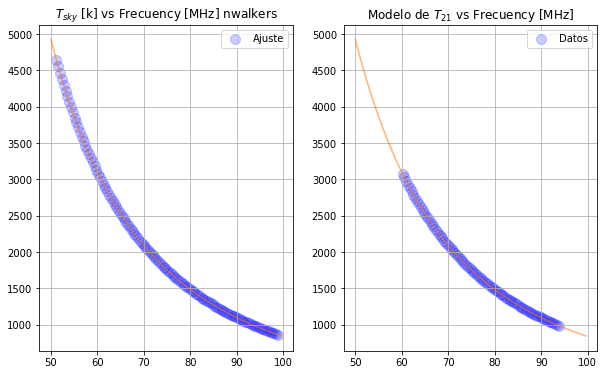

In [15]:
  ii=0
  fig, axs = plt.subplots(1, 2,figsize=(10, 6))
  axs[0].scatter(x,T_sky(x,*popt),color=Col[ii], label='Ajuste',s=100,alpha=0.2)
  for i in range(int(len(params)/1000)):
    axs[0].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  #axs[0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos')
  axs[0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[1].scatter(x_C,y_C,color='b',alpha=0.2,label='Datos',s=100)
  for i in range(int(len(params)/1000)):
    axs[1].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  axs[1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  for ax in axs.flat:
      ax.legend()
      ax.grid()

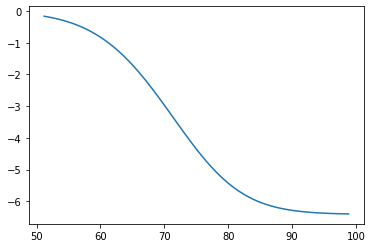

In [16]:
b0,b1,b2,b3,Te,A,v0,w,tau = popt
plt.plot(x,T_21(x, A,v0,w,tau))

In [17]:
sampler=samples
var_names=names
emcee_data = az.from_emcee(sampler, var_names=var_names)
emcee_data
az.rhat(emcee_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b0       float64 1.251
    b1       float64 1.216
    b2       float64 1.257
    b3       float64 1.235
    Te       float64 1.207
    A        float64 1.202
    vo       float64 1.149
    w        float64 1.122
    tau      float64 1.172

In [18]:
def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//10 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=0.065
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      plt.xlabel("Observed Discrepancies")
      plt.xlabel("Simulated Discrepancies")

      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

Rejection rate = 0 %
Bayesian p-value: 0.8306666666666667


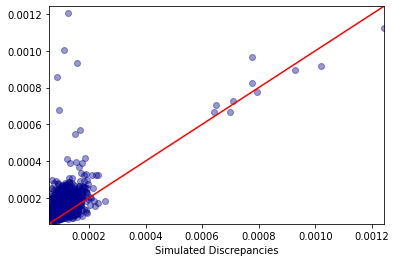

In [19]:
disc(params,x,y)
#plt.xlim(0,3)
#plt.ylim(0,2)

In [20]:
params.shape

(7500, 9)

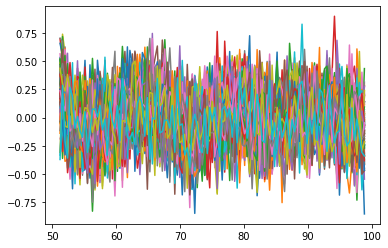

In [21]:
res=[]
for i in range(100):
    selec=np.random.choice(len(params))
    mu=T_sky(x,*params[selec][0:9])
    sig=0.2
    ysim=np.random.normal(mu,sig)
    res+=[y-ysim]
    plt.plot(x,(y-ysim))

# sigma variable

In [22]:
Sol=Sol_forz=np.array([1755, -0.08 ,-0.012,0.0052,1100,0.5,78.3,18.9,7.5,0.025]) # profe
Sol=Sol_forz=np.array([1750.88, -0.067 ,-0.078,0.00006,394,0.5,78.3,18.6,4.5,0.2])
#yerr=0.025

In [23]:
def T_f(v,b0,b1,b2,b3,Te):
  vc=75.0 # frecuancia central (rean) 
  return (b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0)+Te*(1-np.exp(-b3*(v/vc)**-2.0))

def log_like(theta,x,y):
  v=x
  b0,b1,b2,b3,Te,A,v0,w,tau,sigma = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,b0,b1,b2,b3,Te,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
def log_prob(theta, x, y):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x, y)
def log_p(theta):
  b0,b1,b2,b3,Te,A,v0,w,tau,sigma = theta
  if 1700 < b0 < 1800.0 and -0.070 < b1 < -0.007 and  -2.1< b2 < -0.00011 and 0.0000 <b3 < 0.2 and 200 < Te < 2000 and 0.170 < A <8.5 and  76.8< v0 <79.0 and 11.5 <w < 22.0 and 1.0 <tau< 13.0 and 0.02 < sigma <0.92:
  #if 1700 < b0 < 1760.0 and -0.9 < b1 < 0.07 and  -0.9< b2 < 0.11 and -0.10 <b3 < 0.2  and 100 < Te < 2000 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 21.0 and 4.5 <tau< 8.0:
  #if 1740 < b0 < 1760.0 and -0.9 < b1 < 0.07 and  -0.9< b2 < 0.11 and -0.10 <b3 < 0.2 and 100 < Te < 2000 and 0.170 < A <1.9 and  76.8< v0 <82.0 and 10.5 <w < 25.0 and 0.5 <tau< 10.0 and 0.002 < sigma <0.9:
  #if 1740 < b0 < 1760.0 and -0.08 < b1 < -0.0007 and  -2.1< b2 < -0.00011 and 0.00010 <b3 < 0.2 and -2000 < Te < 2500 and 0.170 < A <8.5 and  77.8< v0 <79.0 and 18.5 <w < 20.8 and 4.0 <tau< 10.0 and 0.1 < sigma <0.92:
    return 0.0
  return -np.inf

In [24]:

def nwalk_b(x,y,Sol,walkers,steps):
  N=len(Sol)  
  pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-4*(np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  pos=pos.T  
  nwalkers, ndim = pos.shape  

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler#discard=N, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [25]:
steps=8000 #pasos
walkers=500
samples1=nwalk_b(x,y,Sol,walkers,steps)

100%|██████████| 8000/8000 [06:52<00:00, 19.40it/s]


In [26]:
params=samples1.get_chain(discard=100, thin=200, flat=True)#parametros
params.shape
popt=np.array(params.mean(axis=0))

In [27]:
params.shape

(19500, 10)

Bow


<Figure size 432x288 with 0 Axes>

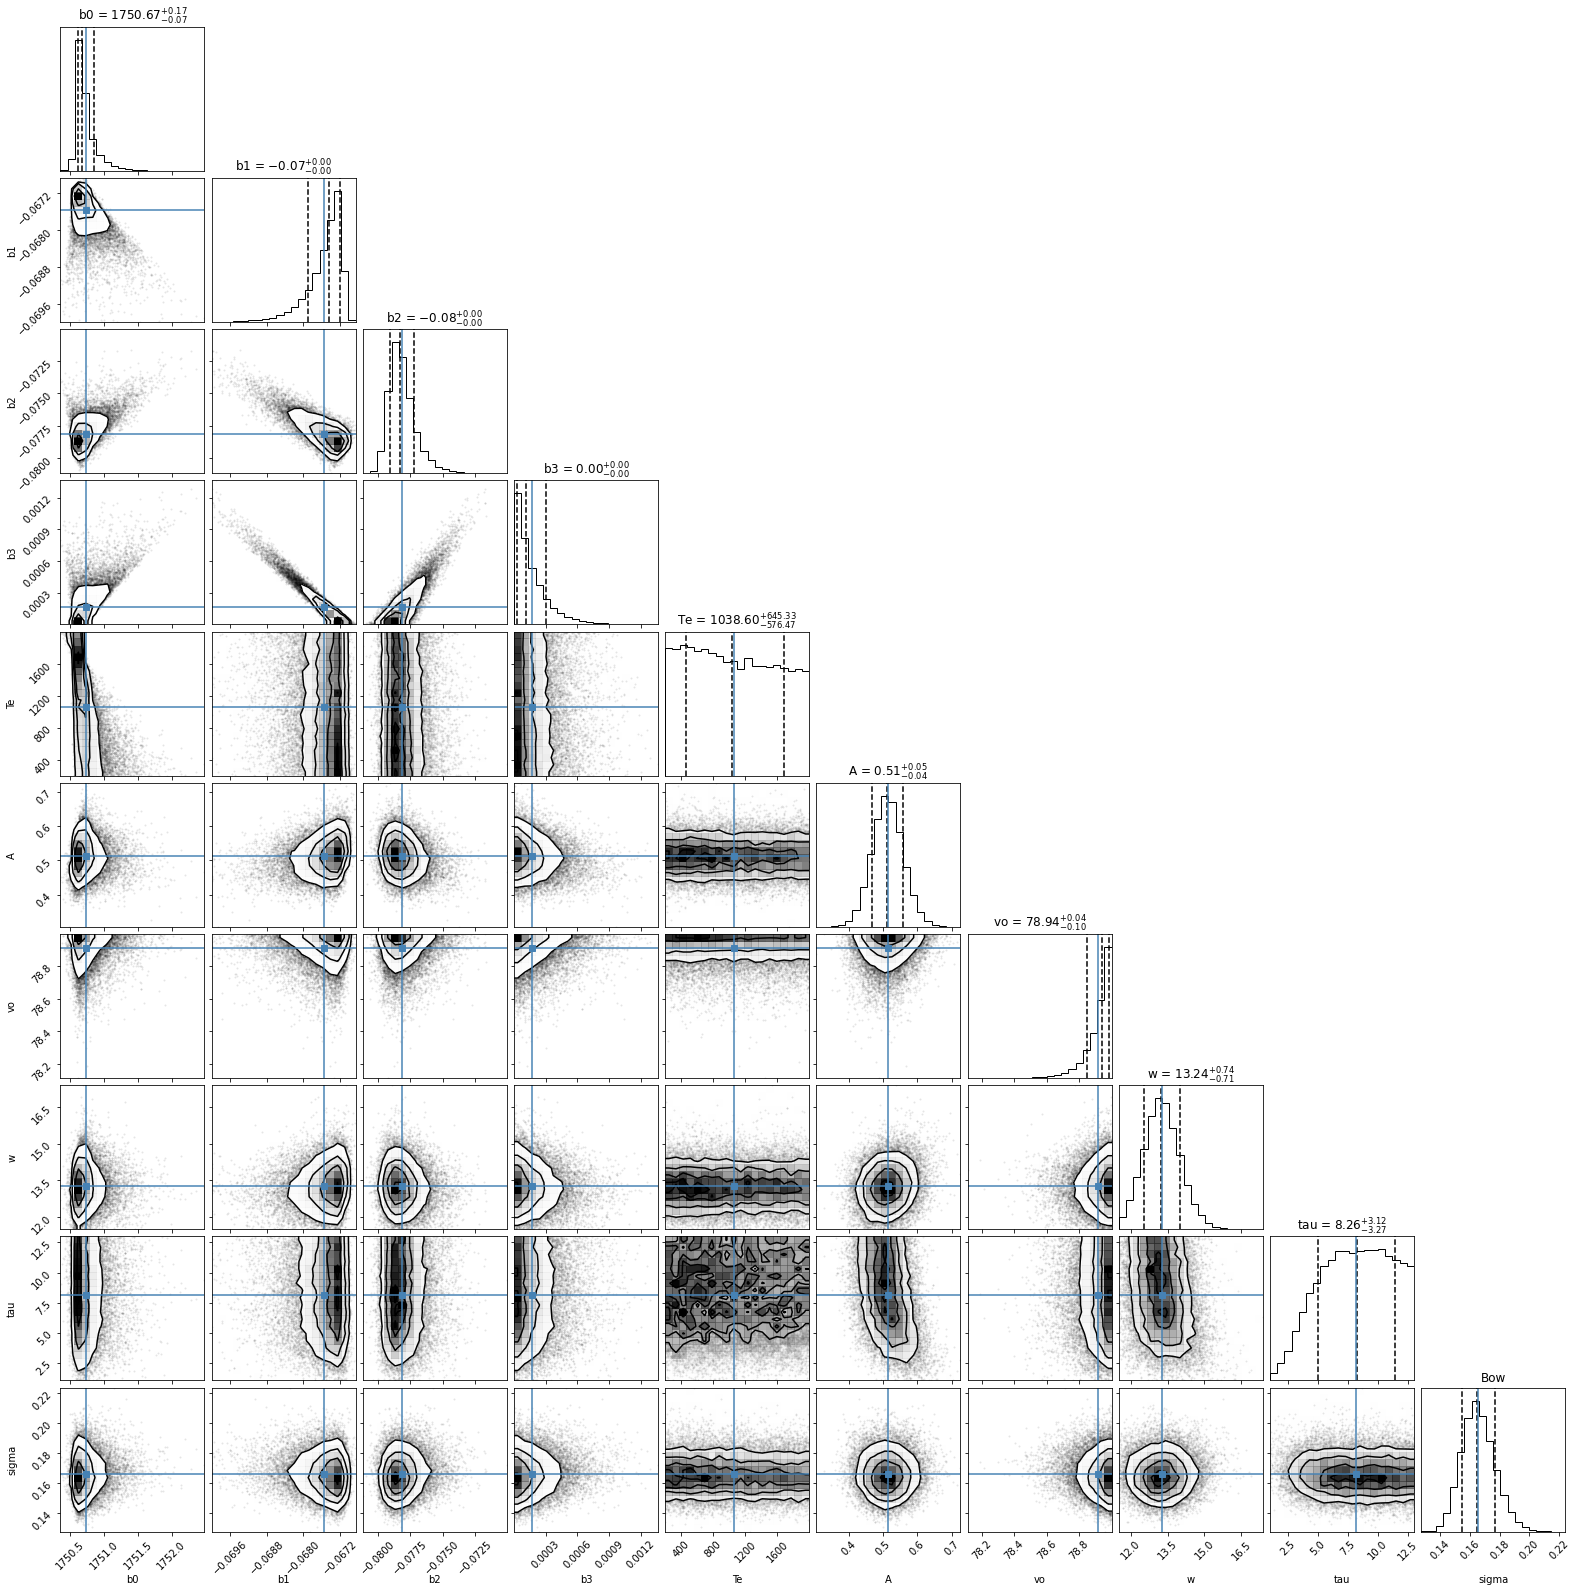

In [28]:
Nlen=1
names=np.array(['b0','b1','b2','b3','Te','A','vo','w','tau','sigma'])
plt.figure()
for i in range(Nlen):
  print(Cons_names[i])
  corner.corner(params,labels=names,quantiles=[0.16, 0.5, 0.84],truths=popt,show_titles=True)
  plt.title(Cons_names[i]) 
plt.show()

In [29]:
sampler=samples1
var_names=names
emcee_data = az.from_emcee(sampler, var_names=var_names)
emcee_data
az.rhat(emcee_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b0       float64 1.084
    b1       float64 1.08
    b2       float64 1.074
    b3       float64 1.083
    Te       float64 1.073
    A        float64 1.042
    vo       float64 1.043
    w        float64 1.039
    tau      float64 1.045
    sigma    float64 1.04

In [30]:
def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//10 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=abs(np.mean(params[:,9]))
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      plt.xlabel("Observed Discrepancies")
      plt.xlabel("Simulated Discrepancies")

      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

Rejection rate = 0 %
Bayesian p-value: 0.9989743589743589


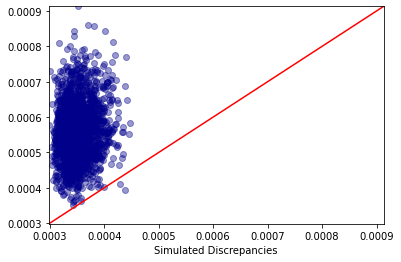

In [31]:
disc(params,x,y)

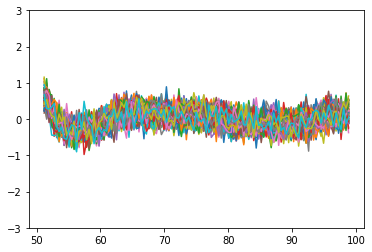

In [32]:
res=[]
for i in range(100):
    selec=np.random.choice(len(params))
    mu=T_sky(x,*params[selec][0:9])
    sig=0.2
    ysim=np.random.normal(mu,sig)
    res+=[y-ysim]
    plt.plot(x,(y-ysim))
    plt.ylim(-3,3)

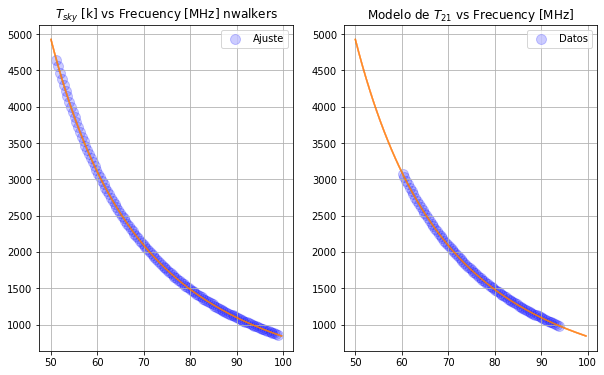

In [33]:
  params=params[:,0:9]
  popt=np.array(params.mean(axis=0))
  
  ii=0
  fig, axs = plt.subplots(1, 2,figsize=(10, 6))
  axs[0].scatter(x,T_sky(x,*popt),color=Col[ii], label='Ajuste',s=100,alpha=0.2)
  for i in range(int(len(params)/1000)):
    axs[0].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  #axs[0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos')
  axs[0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[1].scatter(x_C,y_C,color='b',alpha=0.2,label='Datos',s=100)
  for i in range(int(len(params)/1000)):
    axs[1].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  axs[1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  for ax in axs.flat:
      ax.legend()
      ax.grid()

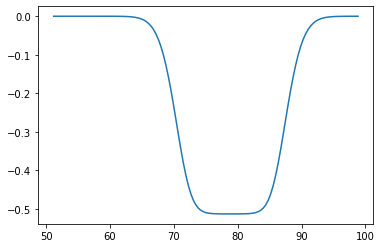

In [34]:
b0,b1,b2,b3,Te,A,v0,w,tau = popt
plt.plot(x,T_21(x, A,v0,w,tau))

In [35]:
def T_modelo(x,y,yerr,const):
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma= const             # intersección con el eje y
  nll=lambda *args: -log_likelihood(*args) # Construccion de la funcion lamda 
  v=x
  N=len(x) 
  vc=78.0
  #Condiciones iniciales
  In=np.array([a0,a1,a2,a3,a4,A,v0,w,tau]) + 0.1 * np.random.randn(9)
  #Solución
  Sol=minimize(nll,In,args=(x, y, yerr))
  # Extrayendo los valores de los parametros arojados por MlE
  popt = Sol.x
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt

  return popt

def nwlakers(x,y,yerr,Sol,N,walkers,steps,i):
  pos = Sol+ 10e-2* np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr,i))
  sampler.run_mcmc(pos, steps, progress=True);
  
  #parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return sampler

def log_likelihood(theta,x,y,yerr):
  v=x
  sigma=yerr
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
def log_probability(theta, x, y, yerr,i):
    lp = log_p(theta,i,Cons_names)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
def log_p (theta,i,Cons_names):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta

  if Cons_names[i]== 'Bow':
    if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0: 
      return 0.0
  return -np.inf 

# Others